In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.measure
import scipy.ndimage

from src.datasets import BiosensorDataset, calculate_mean_and_std
from src.unet import UNet
from src.train import train_model

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

torch.manual_seed(42)

data_path = 'data_with_centers/'
checkpoint_dir = 'checkpoints'
train_percent = 0.86
bio_len = 4
mask_size = 80
batch_size = 4

files = os.listdir(data_path)
train_size = int(train_percent * len(files))
val_size = len(files) - train_size
train_files, val_files = torch.utils.data.random_split(files, [train_size, val_size])

mean, std = calculate_mean_and_std(data_path, train_files, biosensor_length=bio_len)

train_dataset = BiosensorDataset(data_path, train_files, mean, std, bool, biosensor_length=bio_len, mask_size=mask_size, augment=True)
val_dataset = BiosensorDataset(data_path, val_files, mean, std, bool, biosensor_length=bio_len, mask_size=mask_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


model = UNet(n_channels=bio_len, n_classes=1)
model = model.to(device)

Using device cuda


In [29]:
try:
    train_model(
        model,
        device,
        train_loader,
        val_loader,
        learning_rate=0.01,
        epochs=5,
        checkpoint_dir=checkpoint_dir,
        amp=True,
    )
except torch.cuda.OutOfMemoryError:
    torch.cuda.empty_cache()
    print('Detected OutOfMemoryError!')

detection_rate,▆█▁██
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
learning rate,▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▄▄▂▂▅▄▂▂▄▂▂▄▄▂▂▁▂▃▂▄▂▃▂▃▁▃▄▂▃▄▄▂▁▁▁▄▃
validation Dice,▅▆▁██
detection_rate,0.83833
epoch,5
learning rate,0.01
step,175
train loss,0.76372


Starting training:
        Epochs:          5
        Batch size:      4
        Learning rate:   0.01
        Training size:   140
        Validation size: 23
        Device:          cuda
        Mixed Precision: True
    


Epoch 1/5: 100%|██████████| 140/140 [00:20<00:00,  6.92img/s, loss (batch)=0.678]


Validation Dice score: 0.3111799955368042, Detection rate: 0.6004405286343613
Checkpoint 1 saved!


Epoch 2/5: 100%|██████████| 140/140 [00:18<00:00,  7.76img/s, loss (batch)=0.708]


Validation Dice score: 0.3997368812561035, Detection rate: 0.7484581497797357
Checkpoint 2 saved!


Epoch 3/5: 100%|██████████| 140/140 [00:17<00:00,  7.78img/s, loss (batch)=0.587]


Validation Dice score: 0.41188734769821167, Detection rate: 0.7726872246696035
Checkpoint 3 saved!


Epoch 4/5: 100%|██████████| 140/140 [00:18<00:00,  7.77img/s, loss (batch)=0.675]


Validation Dice score: 0.4453393816947937, Detection rate: 0.7876651982378855
Checkpoint 4 saved!


Epoch 5/5: 100%|██████████| 140/140 [00:17<00:00,  7.86img/s, loss (batch)=0.716]

Validation Dice score: 0.4507664144039154, Detection rate: 0.8145374449339207
Checkpoint 5 saved!


In [39]:
from torchsummary import summary

# Load the checkpoint
checkpoint = torch.load("checkpoints/checkpoint_epoch9.pth")

# Get the learning rate and remove it from the checkpoint
lr = checkpoint.pop('learning_rate')

# Load the state dictionary into the model
model.load_state_dict(checkpoint)

# Move the model to the device
model = model.to(device)

# Print the model summary
# summary(model, input_size=(bio_len, mask_size, mask_size))

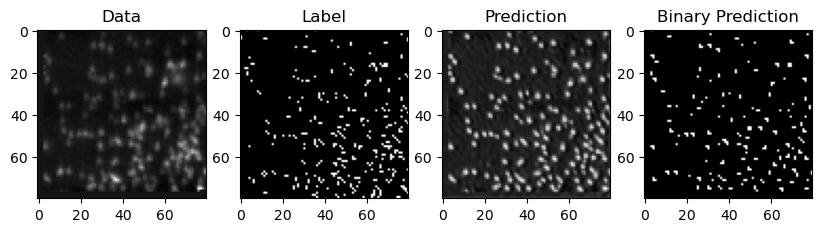

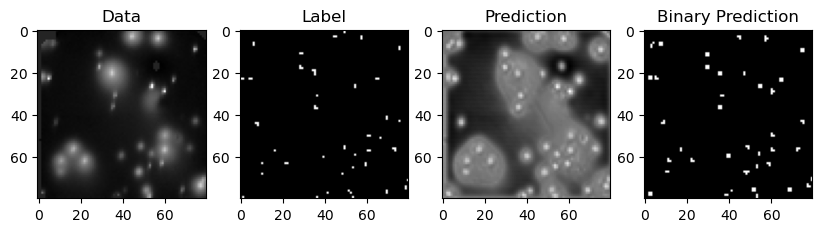

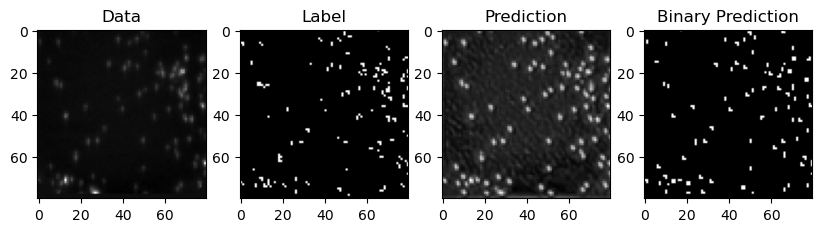

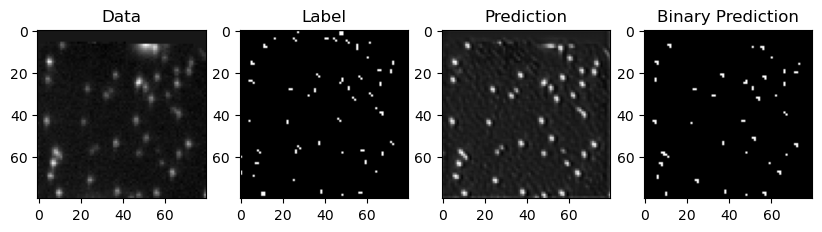

In [40]:
# Load a batch of data and labels
data, labels = next(iter(val_loader))

# Move the data and labels to the device
data = data.to(device)
labels = labels.to(device)

# Get the predictions
predictions = model(data)

# Move the predictions and labels to the CPU and convert them to numpy arrays
predictions = predictions.cpu().detach().numpy()
threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.uint8)


labels = labels.cpu().numpy()

# Plot the data, the labels, and the predictions
for i in range(len(data)):
    plt.figure(figsize=(10, 40))
    
    plt.subplot(1, 4, 1)
    plt.imshow(data[i].cpu().numpy()[10], cmap='gray')
    plt.title('Data')
    
    plt.subplot(1, 4, 2)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.title('Label')
    
    plt.subplot(1, 4, 3)
    plt.imshow(np.squeeze(predictions[i]), cmap='gray')
    plt.title('Prediction')

    plt.subplot(1, 4, 4)
    plt.imshow(np.squeeze(binary_predictions[i]), cmap='gray')
    plt.title('Binary Prediction')
    
    plt.show()

In [41]:
def cell_detection_skimage(model, val_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    total_cells = 0
    detected_cells = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, labels in val_loader:
            # Move the data and labels to the device
            data = data.to(device)
            labels = labels.to(device)

            # Get the predictions
            predictions = model(data)

            # Move the predictions and labels to the CPU and convert them to numpy arrays
            predictions = predictions.cpu().detach().numpy()
            binary_predictions = (predictions > threshold).astype(np.uint8)

            labels = labels.cpu().numpy()

            for i in range(len(data)):
                # Label the binary prediction and count the number of cells
                _, num_cells_pred = skimage.measure.label(binary_predictions[i], return_num=True, connectivity=2)
                _, num_cells_label = skimage.measure.label(labels[i], return_num=True, connectivity=2)

                total_cells += num_cells_label
                detected_cells += num_cells_pred

    cell_detection_rate = detected_cells / total_cells if total_cells > 0 else 0

    return cell_detection_rate, total_cells, detected_cells

In [42]:
def cell_detection_scipy(model, val_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    total_cells = 0
    detected_cells = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, labels in val_loader:
            # Move the data and labels to the device
            data = data.to(device)
            labels = labels.to(device)

            # Get the predictions
            predictions = model(data)

            # Move the predictions and labels to the CPU and convert them to numpy arrays
            predictions = predictions.cpu().detach().numpy()
            binary_predictions = (predictions > threshold).astype(np.uint8)

            labels = labels.cpu().numpy()

            structure = np.ones((3, 3))

            for i in range(len(data)):
                # Label the binary prediction and count the number of cells
                _, num_cells_pred = scipy.ndimage.label(np.squeeze(binary_predictions[i]), structure=structure)
                _, num_cells_label = scipy.ndimage.label(labels[i], structure=structure)

                total_cells += num_cells_label
                detected_cells += num_cells_pred

    cell_detection_rate = detected_cells / total_cells if total_cells > 0 else 0

    return cell_detection_rate, total_cells, detected_cells

In [43]:
cell_detection_rate, total, detected = cell_detection_skimage(model, val_loader, device)
print(f'Cell detection rate: {cell_detection_rate}, total cells: {total}, detected cells: {detected}')

Cell detection rate: 0.8004405286343612, total cells: 2270, detected cells: 1817


In [44]:
cell_detection_rate, total, detected = cell_detection_scipy(model, val_loader, device)
print(f'Cell detection rate: {cell_detection_rate}, total cells: {total}, detected cells: {detected}')

Cell detection rate: 0.8004405286343612, total cells: 2270, detected cells: 1817
